# Generative Medical Image Segmentation

In [118]:
# --- Import Libraries ---
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro import poutine
from pyro.optim import Adam
from pyro.nn import PyroModule
from torch import nn
import torch.nn.functional as F
import sys
import os


sys.path.append(os.path.join(os.getcwd(), ".."))

from scripts.data import get_loaders
from scripts.funcs import run_model
from scripts.funcs import print_losses

# Define device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"


# --- Set Plot Style ---
sns.set_style("dark")
plt.style.use("dark_background")


# --- Define Parameters ---
BATCH_SIZE = 64
IMG_SIZE = 64
NUM_WORKERS = 0

### Define Dataloaders

In [119]:
train_loader, test_loader = get_loaders("../data/", batch_size=BATCH_SIZE, img_size=IMG_SIZE, num_workers=NUM_WORKERS)

Train set size: 3536
Test set size: 393


### Define Hierarchical VAE

In [120]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True))

class ButtomUpEncoder(nn.Module):                    
    def __init__(self, z_dims=[64, 32, 16]):
        super().__init__()
        self.enc1 = double_conv(3,   16)
        self.enc2 = double_conv(16,  32)
        self.enc3 = double_conv(32,  64)
        self.enc4 = double_conv(64, 128)

        # Output layers for statistics
        self.to_statsh1 = nn.Sequential(           
            nn.Conv2d(32, 2*z_dims[0], 1),
            nn.AdaptiveAvgPool2d(1))
        self.to_statsh2 = nn.Sequential(           
            nn.Conv2d(64, 2*z_dims[1], 1),
            nn.AdaptiveAvgPool2d(1))
        self.to_statsh3 = nn.Sequential(           
            nn.Conv2d(128, 2*z_dims[2], 1),
            nn.AdaptiveAvgPool2d(1))
         
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))
        x4 = self.enc4(self.pool(x3))


        h1 = self.to_statsh1(x2).flatten(1)  
        h2 = self.to_statsh2(x3).flatten(1)
        h3 = self.to_statsh3(x4).flatten(1)

        return h1, h2, h3
    
class Decoder(nn.Module):
    
    def __init__(self, z_dim=64, start_ch=128, img_size=32):
        super().__init__()
        self.img_size = img_size
        fsz = img_size // 16                             
        self.fc = nn.Linear(z_dim, start_ch * fsz * fsz)

        self.up1 = double_conv(start_ch, 128)
        self.up2 = double_conv(128,  64)
        self.up3 = double_conv(64,   32)
        self.up4 = double_conv(32,   16)

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear",
                                    align_corners=False)
        
        self.out_conv = nn.Conv2d(16, 1, 1)      

    def forward(self, z):
        B = z.size(0)
        fsz = self.img_size // 16
        x = self.fc(z).view(B, 128, fsz, fsz)

        x = self.up1(x)
        x = self.upsample(x)   
        x = self.up2(x) 
        x = self.upsample(x)   
        x = self.up3(x) 
        x = self.upsample(x)   
        x = self.up4(x) 
        x = self.upsample(x)  
        return torch.sigmoid(self.out_conv(x))          

                        

In [121]:
class HierarchicalVAE(PyroModule):
    def __init__(self, z_dims=[32,16,8], hidden_dim=128):
        super().__init__()
        self.z_dims = z_dims
        self.buttom_up = ButtomUpEncoder(z_dims=z_dims)
        self.decoder = Decoder(z_dim=z_dims[0] + z_dims[0]*2, start_ch=128, img_size=IMG_SIZE)
        self.hidden_dim = hidden_dim

        # priors p(z_i | z_{>i}) 
        self.prior2 = nn.Sequential(
            nn.Linear(z_dims[2], hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 2*z_dims[1])
        )
        self.prior1 = nn.Sequential(
            nn.Linear(z_dims[1]+z_dims[2], hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 2*z_dims[0])
        )

        # posteriors q(z_i | h_i, z_{>i})
        self.post3 = nn.Sequential(
            nn.Linear(2 * z_dims[2], hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 2 * z_dims[2])
        )
        self.post2 = nn.Sequential(
            nn.Linear(2 * z_dims[1] + z_dims[2], hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 2 * z_dims[1])
        )
        self.post1 = nn.Sequential(
            nn.Linear(2 * z_dims[0] + z_dims[1] + z_dims[2], hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 2 * z_dims[0])
        )

    def model(self, x, y=None):
        pyro.module("HierarchicalVAE", self)
        batch_size = x.size(0)
        with pyro.plate("data", batch_size):
            
            # Sample from priors
            z3_loc = torch.zeros(x.shape[0], self.z_dims[2], dtype=x.dtype, device=device)
            z3_scale = torch.ones(x.shape[0], self.z_dims[2], dtype=x.dtype, device=device)
            z3 = pyro.sample("z3", dist.Normal(z3_loc, z3_scale).to_event(1)) 

            z2_loc, z2_logscale = self.prior2(z3).chunk(2, dim=-1)
            z2_scale = F.softplus(0.5 * z2_logscale)
            z2 = pyro.sample("z2", dist.Normal(z2_loc, z2_scale).to_event(1)) 

            z1_loc, z1_logscale = self.prior1(torch.cat([z2, z3], dim=-1)).chunk(2, dim=-1)
            z1_scale = F.softplus(0.5 * z1_logscale)
            z1 = pyro.sample("z1", dist.Normal(z1_loc, z1_scale).to_event(1)) 

            # get first feature map
            h1, _, _ = self.buttom_up(x)

            # Decode
            yhat = self.decoder(torch.cat([z1, h1], dim=-1))
            if y is not None:
                pyro.sample("yhat", dist.Bernoulli(yhat).to_event(3), obs=y)
            else:
                pyro.deterministic('yhat', yhat.detach())
            return yhat
        
    def guide(self, x, y=None):
        pyro.module("HierarchicalVAE", self)
        batch_size = x.size(0)
        with pyro.plate("data", batch_size):
            h1, h2, h3 = self.buttom_up(x)

            # Sample from posteriors
            z3_loc, z3_logscale = self.post3(h3).chunk(2, dim=-1)
            z3_scale = F.softplus(0.5 * z3_logscale)
            z3 = pyro.sample("z3", dist.Normal(z3_loc, z3_scale).to_event(1)) 

            z2_loc, z2_logscale = self.post2(torch.cat([h2, z3], dim=-1)).chunk(2, dim=-1)
            z2_scale = F.softplus(0.5 * z2_logscale)
            z2 = pyro.sample("z2", dist.Normal(z2_loc, z2_scale).to_event(1))  

            z1_loc, z1_logscale = self.post1(torch.cat([h1, z2, z3], dim=-1)).chunk(2, dim=-1)
            z1_scale = F.softplus(0.5 * z1_logscale)
            z1 = pyro.sample("z1", dist.Normal(z1_loc, z1_scale).to_event(1))
        
 

In [122]:
# Test forward pass
hvae = HierarchicalVAE(z_dims=[64, 32, 16]).to(device)
x = torch.randn(64, 3, 32, 32).to(device)
y_hat = hvae.model(x)
# Print output shape
print("Output shape:", y_hat.shape)

Output shape: torch.Size([64, 1, 64, 64])


In [123]:
# --- Define KL Annealing Loss ---
def elbo_kl_annealing(model, guide, x, y=None, latents_to_anneal=["latent"], beta=1.0):
    # get the annealing factor and latents to anneal from the keyword
    # arguments passed to the model and guide
    annealing_factor = beta
    latents_to_anneal = latents_to_anneal
    # run the guide and replay the model against the guide
    guide_trace = poutine.trace(
        guide).get_trace(x, y)
    
    model_trace = poutine.trace(
        poutine.replay(model, trace=guide_trace)).get_trace(x, y)

    elbo = 0.0
    # loop through all the sample sites in the model and guide trace and
    # construct the loss; note that we scale all the log probabilities of
    # samples sites in `latents_to_anneal` by the factor `annealing_factor`
    for site in model_trace.nodes.values():
        if site["type"] == "sample":
            factor = annealing_factor if site["name"] in latents_to_anneal else 1.0
            elbo = elbo + factor * site["fn"].log_prob(site["value"]).sum()
    for site in guide_trace.nodes.values():
        if site["type"] == "sample":
            factor = annealing_factor if site["name"] in latents_to_anneal else 1.0
            elbo = elbo - factor * site["fn"].log_prob(site["value"]).sum()
    return -elbo

In [124]:
# --- Training the VAE ---
num_epochs = 50
test_frequency = 10
lr = 5e-5

hvae = HierarchicalVAE(z_dims=[64,32,16], hidden_dim=32).to(device)

# setup the optimizer
optimizer = Adam({"lr": lr})
svi = SVI(hvae.model, hvae.guide, optimizer, loss=elbo_kl_annealing)

hvae = run_model(hvae, svi, train_loader, test_loader, 
                 num_epochs=num_epochs, test_frequency=test_frequency, 
                 warmup_epochs=25, latents=["z1", "z2", "z3"], device=device)

[Epoch 1]
Mean training elbo: 2882.3662
Beta: 0.0000

[Epoch 2]
Mean training elbo: 706.3449
Beta: 0.0400

[Epoch 3]
Mean training elbo: 431.1370
Beta: 0.0800

[Epoch 4]
Mean training elbo: 289.4990
Beta: 0.1200

[Epoch 5]
Mean training elbo: 203.8409
Beta: 0.1600

[Epoch 6]
Mean training elbo: 187.3577
Beta: 0.2000

[Epoch 7]
Mean training elbo: 186.4680
Beta: 0.2400

[Epoch 8]
Mean training elbo: 184.0116
Beta: 0.2800

[Epoch 9]
Mean training elbo: 184.1060
Beta: 0.3200

[Epoch 10]
Mean training elbo: 183.6691
Beta: 0.3600
Mean test loss: 170.8508

[Epoch 11]
Mean training elbo: 184.9385
Beta: 0.4000

[Epoch 12]
Mean training elbo: 183.3644
Beta: 0.4400

[Epoch 13]
Mean training elbo: 183.1999
Beta: 0.4800

[Epoch 14]
Mean training elbo: 183.3164
Beta: 0.5200

[Epoch 15]
Mean training elbo: 182.1529
Beta: 0.5600

[Epoch 16]
Mean training elbo: 182.1182
Beta: 0.6000

[Epoch 17]
Mean training elbo: 181.4979
Beta: 0.6400

[Epoch 18]
Mean training elbo: 180.7267
Beta: 0.6800

[Epoch 19]


In [125]:
def predict(x):
    posterior_predictive = Predictive(hvae.model, guide=hvae.guide, num_samples=1)
    samples = posterior_predictive(x, None)
    pred = samples["yhat"]  
    pred = pred.squeeze(0) 
    return pred
    
# Model evaluation
hvae.eval()
with torch.no_grad():
    print_losses(test_loader, hvae, predict, device)

BCE loss:
0.04

Average DICE score:
0.65

ELBO loss:
160.34


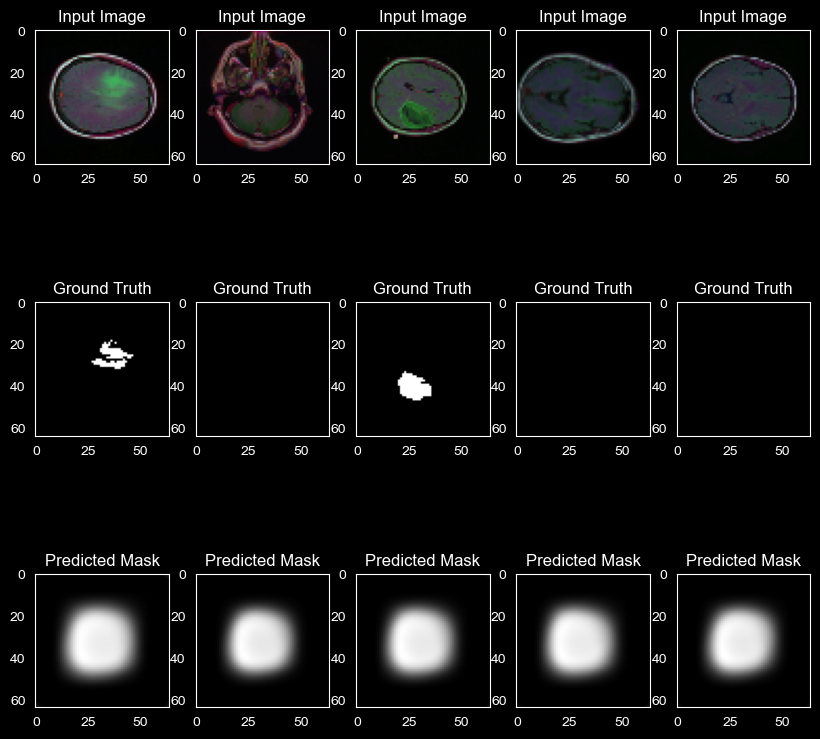

In [126]:
# Visualize the model predictions
def visualize_predictions(model, dataloader, num_images=5):
    model.eval()
    with torch.no_grad():
        images, labels = next(iter(dataloader))
        images = images.to(device)
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225] 
        labels = labels.to(device)
        with torch.no_grad():
            outputs = predict(images)
        # outputs[outputs < 0.5] = 0
        images = images.cpu().numpy()
        labels = labels.cpu().numpy()
        outputs = outputs.cpu().numpy()
        fig, axes = plt.subplots(3, num_images, figsize=(10, 10))
        for i in range(num_images):
            axes[0, i].imshow((images[i].transpose(1, 2, 0)*std + mean).clip(0, 1))
            axes[0, i].set_title("Input Image")
            axes[1, i].imshow(labels[i].squeeze(), cmap='gray')
            axes[1, i].set_title("Ground Truth")
            axes[2, i].imshow(outputs[i].squeeze(), cmap='gray')
            axes[2, i].set_title("Predicted Mask")

visualize_predictions(hvae, test_loader)